In [87]:
pip install yfinance pandas numpy scipy matplotlib  riskfolio-lib dataframe_image

### Import libraries

In [88]:
import warnings
import riskfolio as rp
import matplotlib.pyplot as plt
import dataframe_image as dfi
from IPython.display import display, Markdown, FileLink
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import pandas as pd
import yfinance as yf

# Suppress warnings
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.6f}'.format


### Prepare Data

In [103]:
# PARAMETERS
start = '2022-01-01' #This is out-of sample data : if you want to know the In-sample performance change to 2018-01-01
end = '2022-12-31' # same applies here; if you want In-sample performance change to 2021-12-31
trading_days = 250
rf = 0  # risk-free rate

# SECTOR DEFINITIONS
sector_tickers = {
    'NIFTY_Commodities': ['RELIANCE.NS', 'ULTRACEMCO.NS', 'TATASTEEL.NS', 'NTPC.NS', 'JSWSTEEL.NS', 'ONGC.NS', 'GRASIM.NS', 'HINDALCO.NS', 'COALINDIA.NS', 'UPL.NS'],
    'NIFTY_Energy': ['RELIANCE.NS', 'NTPC.NS', 'POWERGRID.NS', 'ONGC.NS', 'TATAPOWER.NS', 'BPCL.NS', 'IOC.NS', 'GAIL.NS', 'ADANIGREEN.NS'],
    'NIFTY_Manufacturing': ['SUNPHARMA.NS', 'RELIANCE.NS', 'M&M.NS', 'TATASTEEL.NS', 'MARUTI.NS', 'JSWSTEEL.NS', 'HINDALCO.NS', 'TATAMOTORS.NS', 'DRREDDY.NS', 'CIPLA.NS'],
    'NIFTY_Services': ['HDFCBANK.NS', 'ICICIBANK.NS', 'INFY.NS', 'TCS.NS', 'KOTAKBANK.NS', 'AXISBANK.NS', 'SBIN.NS', 'BHARTIARTL.NS', 'BAJFINANCE.NS'],
    'NIFTY_MNC': ['MARUTI.NS', 'HINDUNILVR.NS', 'NESTLEIND.NS', 'BRITANNIA.NS', 'VEDL.NS', 'SIEMENS.NS', 'AMBUJACEM.NS', 'CUMMINSIND.NS', 'ASHOKLEY.NS'],
    'NIFTY_Transportation': ['M&M.NS', 'MARUTI.NS', 'TATAMOTORS.NS', 'ADANIPORTS.NS', 'EICHERMOT.NS', 'BAJAJ-AUTO.NS', 'HEROMOTOCO.NS', 'TIINDIA.NS', 'TVSMOTOR.NS', 'ASHOKLEY.NS'],
    'NIFTY_Infrastructure': ['RELIANCE.NS', 'LT.NS', 'BHARTIARTL.NS', 'ULTRACEMCO.NS', 'NTPC.NS', 'POWERGRID.NS', 'ONGC.NS', 'GRASIM.NS', 'APOLLOHOSP.NS', 'ADANIPORTS.NS'],
    'NIFTY_Housing': ['RELIANCE.NS', 'LT.NS', 'BHARTIARTL.NS', 'ULTRACEMCO.NS', 'NTPC.NS', 'POWERGRID.NS', 'ONGC.NS', 'GRASIM.NS', 'TATASTEEL.NS', 'JSWSTEEL.NS'],
    'NIFTY_Consumption': ['ITC.NS', 'HINDUNILVR.NS', 'BHARTIARTL.NS', 'ASIANPAINT.NS', 'M&M.NS', 'MARUTI.NS', 'TITAN.NS', 'NESTLEIND.NS', 'BRITANNIA.NS', 'DMART.NS'],
    'NIFTY_100_ESG': ['INFY.NS', 'TCS.NS', 'HCLTECH.NS', 'ICICIBANK.NS', 'BHARTIARTL.NS', 'TECHM.NS', 'KOTAKBANK.NS', 'BAJFINANCE.NS', 'TITAN.NS']
}

# DATA PREPARATION
print("Preparing data...")
rows = []
for sector, tickers in sector_tickers.items():
    for ticker in tickers:
        rows.append({'Assets': ticker, 'Sector': sector})
sector_df = pd.DataFrame(rows).drop_duplicates()
#print(sector_df)
#invalid_tickers = ['ADANITRANS.NS', 'MCDOWELL-N.NS', 'HDFC.NS']
#sector_df = sector_df[~sector_df['Assets'].isin(invalid_tickers)]
assets = sector_df['Assets'].unique().tolist()
assets.sort()
#print(assets)

Preparing data...


### Download Data

In [90]:
print(f"Downloading data for {len(assets)} stocks...")
data = yf.download(assets, start=start, end=end, auto_adjust=True, progress=False)['Close']
data = data.dropna(axis=1, how='all')
#print(data.head())

### Compute Daily returns of each asset

In [91]:
Y_assets = data.pct_change().replace([np.inf, -np.inf], np.nan)
#print(Y_assets)
Y_assets = Y_assets.fillna(method='ffill').fillna(method='bfill').dropna(axis=1)# handle missing values
#print(Y_assets)
sector_df = sector_df[sector_df['Assets'].isin(Y_assets.columns)] #append assets whose returns missing values have been handled into the sector dataframe
#print(sector_df)

### Set Up the Optimisation for Baseline models(Mean-variance, Minimum-variance and Risk Parity )

In [92]:
# PORTFOLIO OPTIMIZATION
print("Running portfolio optimizations...")
port = rp.Portfolio(returns=Y_assets) # create an instance of the portfolio class 
port.assets_stats(method_mu='hist', method_cov='hist') # this is the portfolio method that computes the expected returns and covariance matrix using the historical returns

# --- MVO Optimization ---
w_mvo = port.optimization(model='Classic', rm='MV', obj='Sharpe', rf=rf, hist=True).squeeze() #we get optimal weights that maximizes the expected returns
w_mvp = port.optimization(model = 'Classic', rm= 'MV', obj = 'MinRisk', rf=rf, hist = True).squeeze() # we get optimal weights that minimizes the risk

# --- Risk Parity Optimization ---
w_rp = port.rp_optimization(model='Classic', rm='MV', rf=rf, hist=True).squeeze() # we get the optimal weights that equalizes the risk contributions of assets


Running portfolio optimizations...


### Set Up a supervised learning model (Random forest) and Hierarchical risk parity( uses Hierarchical clustering(unsupervised learning) and Graph theory)

In [93]:

# --- HRP Optimization ---
print("Running Hierarchical clustering...")
hcp = rp.HCPortfolio(returns=Y_assets) #Initialize the Hierarchical risk parity object; we will use historical returns

w_hrp = hcp.optimization(model='HRP', codependence='distance', rm='MV', rf=rf, linkage='ward', leaf_order=True).squeeze() 
# We are using the hierarchical risky parity model
# We use the distance to get how close/ similar assets are so that they can be clustered based on the distance. D_i_j = square_root(0.5*(1-P_i_j))
# After assets have been clustered we use the ward linkage to minimize the variance of assets within clusters(ward is a clustering method)
# This improves the diversification structure ( leaf order active the leafs of the tree to minimize the distance between assets)


# --- RANDOM FOREST PREDICTED RETURNS ---
print("Training Random Forest on historical adjusted close prices...")
rf_predictions = pd.DataFrame(index=Y_assets.index, columns=Y_assets.columns) # create an empty dataframe that will contain random forest predicted daily returns
# we want this frame to match the same one for historical returns

#set up the feature and the target
# Go through every asset in the Y_asset ( to ensure that every asset return series is treated as a target)
for asset in Y_assets.columns:
    X = data[asset].values.reshape(-1, 1)  # We are using adjusted close as a feature ( adjusted close are contained in data)
    y = Y_assets[asset].values  # Returns as target (returns are contained in Y_assets)

    # Ensure that we do not train our model where there are missing values
    # Create a mask to filter out NaN values
    mask = ~np.isnan(X.flatten()) & ~np.isnan(y)  # mask is a truth value where X and Y  contains no missing values
    X_filtered = X[mask] # we only filter out where mask returns true ( X_filtered contains features with no missing values)
    y_filtered = y[mask]  # same here, Y_filtered contains returns with no missing values
    


    # Train the random forest model
    if len(X_filtered) > 0:  # Only train if we have valid data ; ensures that there is 
        rf_model = RandomForestRegressor(n_estimators=100, random_state=42) # random forest uses decisions trees , I choose 100 trees and 42 as a seed
        rf_model.fit(X_filtered, y_filtered) # fit the model into the datapoints so that it learns

        # Predict the returns using "adjusted close as X-values" 
        # Only predict on non-NaN values
        pred_mask = ~np.isnan(X.flatten()) # ensure that the X-values that we are predicting on are real , we dont predict using null-values
        X_pred = X[pred_mask]
        y_pred = np.full(len(X), np.nan)  # Initialize with NaNs
        y_pred[pred_mask] = rf_model.predict(X_pred) # make prediction on valid x-values
        rf_predictions[asset] = y_pred # rf_predictions[asset] contains the predicted returns of the assets
    else:
        rf_predictions[asset] = np.nan
        # Mathematically this works like a piecewise function ; 

# Fill any remaining NaN values in predictions
rf_predictions = rf_predictions.fillna(method='ffill').fillna(method='bfill')


Running Hierarchical clustering...
Training Random Forest on historical adjusted close prices...


### From the predicted  random forest returns; compute the expected returns and ML-drived portfolios

In [94]:
# Compute expected predicted returns 
predicted_mu = rf_predictions.mean() 
# Replace portfolio expected returns with RF predictions
port.mu = predicted_mu

# RF-MVO Optimization using predicted returns
w_rf_mvo = port.optimization(model='Classic', rm='MV', obj='Sharpe', rf=rf, hist=True).squeeze()


### Normalize all the weights

In [95]:
# Normalize weights
w_mvo = w_mvo / w_mvo.sum()
w_rp = w_rp / w_rp.sum()
w_hrp = w_hrp / w_hrp.sum()
w_rf_mvo = w_rf_mvo / w_rf_mvo.sum()

# COMBINE ALL WEIGHTS
weights_df = pd.DataFrame({
    'Assets': w_mvo.index,
    'MV Weight': w_mvo,
    'RP Weight': w_rp,
    'HRP Weight': w_hrp,
    'RF-MV Weight': w_rf_mvo
}).merge(sector_df, on='Assets')


### Marginal Contribution to Risk

In [96]:
# --- MARGINAL CONTRIBUTION TO RISK FUNCTION ---
def calculate_mcr(weights, cov_matrix):
    port_var = np.dot(weights.values, np.dot(cov_matrix.values, weights.values)) # this is the variance of the portfolio
    port_std = np.sqrt(port_var) # standard deviation of the portfolio
    mcr = np.dot(cov_matrix.values, weights.values) / port_std # this is the marginal contribution to portfolio risk ( sigm@weights/standard deviation)
    return pd.Series(mcr, index=weights.index)

cov_matrix = port.cov
mcr_mvo = calculate_mcr(w_mvo, cov_matrix)  # compute the marginal contrbution to Portfolio(MVO) risk of every asset in the MVO portfolio
mcr_rp = calculate_mcr(w_rp, cov_matrix) # compute the marginal contribution to Portfolio(Risk Parity) risk of every asset in the Risk Parity Portfolio
mcr_hrp = calculate_mcr(w_hrp, cov_matrix) # Compute the marginal contrbution to Portfolio(HRP) risk of every asset in the Hierarchical risk parity portfolio
mcr_rf_mvo = calculate_mcr(w_rf_mvo, cov_matrix) # Compute the marginal contribution to Portfolio(RF-INDUCED MVO) of every asset in the RF-MVO POrtfolio

### Performance Calculation

In [97]:
# --- PERFORMANCE CALCULATION ---
def calculate_performance(returns, name, trading_days=250, rf=0):
    ann_ret = returns.mean() * trading_days
    ann_vol = returns.std() * np.sqrt(trading_days)
    sharpe = (ann_ret - rf) / ann_vol if ann_vol > 0 else np.nan
    return {
        'Portfolio': name,
        'Annual Return': ann_ret,
        'Annual Volatility': ann_vol,
        'Sharpe Ratio': sharpe
    }

performance_data = [] # this list will contain the performance informantion of every portfolio
for sector in weights_df['Sector'].unique(): # loop every sector in the name weight dataframe
    sector_data = weights_df[weights_df['Sector'] == sector] # sector data contains weights of assets in the current sector
    assets = sector_data['Assets'].values # assets is the list of assets names in the current sector
    
    mvo_returns = Y_assets[assets].multiply(sector_data['MV Weight'].values, axis=1).sum(axis=1)
    # select only the return series of the assets in the current secto
    # Then multiply each assets return series by its optimal mvo weights in that sector
    # then sum all the assets weighted returns for every date to get the mvo portfolio return time series
    #Do the same calculation for risk parity, hrp and random forest
      
    rp_returns = Y_assets[assets].multiply(sector_data['RP Weight'].values, axis=1).sum(axis=1)
    hrp_returns = Y_assets[assets].multiply(sector_data['HRP Weight'].values, axis=1).sum(axis=1)
    rf_mvo_returns = Y_assets[assets].multiply(sector_data['RF-MV Weight'].values, axis=1).sum(axis=1)

    # Now, compute the portfolio performance in every sector and append those results in the performance data list
    performance_data.append(calculate_performance(mvo_returns, f"{sector} (MV)", rf=rf))
    performance_data.append(calculate_performance(rp_returns, f"{sector} (RP)", rf=rf))
    performance_data.append(calculate_performance(hrp_returns, f"{sector} (HRP)", rf=rf))
    performance_data.append(calculate_performance(rf_mvo_returns, f"{sector} (RF-MV)", rf=rf))

performance_df = pd.DataFrame(performance_data) # Turn our list to a dataframe 

### Average Marginal contribution to Risk per sector

In [98]:
# --- AVG MCR PER SECTOR ---
mcr_summary = [] # create an empty list that will contain the marginal contribution to risk of every sector in every portfolio
for sector in weights_df['Sector'].unique():
    sector_assets = weights_df[weights_df['Sector'] == sector]['Assets'] # select/returns  the assets in the current sector
    #We select only the marginal contribution to risk values of assets in the current sector.
    # To get how much risk the sector contributes to the portfolio we take average of the mcr's in the sector
    # we do this for all the portfolio to know which sector contributes more risk to the portfolio
    mcr_summary.append({'Portfolio': f"{sector} (MV)", 'Avg Marginal Contribution to Risk': mcr_mvo.loc[sector_assets].mean()}) 
    mcr_summary.append({'Portfolio': f"{sector} (RP)", 'Avg Marginal Contribution to Risk': mcr_rp.loc[sector_assets].mean()})
    mcr_summary.append({'Portfolio': f"{sector} (HRP)", 'Avg Marginal Contribution to Risk': mcr_hrp.loc[sector_assets].mean()})
    mcr_summary.append({'Portfolio': f"{sector} (RF-MV)", 'Avg Marginal Contribution to Risk': mcr_rf_mvo.loc[sector_assets].mean()})

mcr_summary_df = pd.DataFrame(mcr_summary) 
performance_df = performance_df.merge(mcr_summary_df, on='Portfolio')


### Plots and Tables

In [99]:
# --- TABLES AND PLOTS ---
def save_table(df, title, filename):
    formatted_df = df.copy() # creates a  deep copy
    formatted_df['Annual Return'] = formatted_df['Annual Return'].map('{:.2%}'.format)
    formatted_df['Annual Volatility'] = formatted_df['Annual Volatility'].map('{:.2%}'.format)
    formatted_df['Sharpe Ratio'] = formatted_df['Sharpe Ratio'].map('{:.2f}'.format)
    formatted_df['Avg Marginal Contribution to Risk'] = formatted_df['Avg Marginal Contribution to Risk'].map('{:.6f}'.format)
    styled = (formatted_df.style.set_caption(title).set_properties(**{'text-align': 'center'}))
    dfi.export(styled, f'{filename}.png', table_conversion='matplotlib')
    df.to_excel(f'{filename}.xlsx', float_format="%.6f")
    return styled


def generate_sector_tables(weights_df):
    unique_weights = weights_df.drop_duplicates(subset='Assets')
    for sector in weights_df['Sector'].unique():
        sector_assets = weights_df[weights_df['Sector'] == sector]['Assets'].unique()
        sector_data = unique_weights[unique_weights['Assets'].isin(sector_assets)]
        sector_mvo_weight = sector_data['MV Weight'].sum()
        sector_rp_weight = sector_data['RP Weight'].sum()
        sector_hrp_weight = sector_data['HRP Weight'].sum()
        sector_rf_mvo_weight = sector_data['RF-MV Weight'].sum()
        sector_data = sector_data.copy()
        sector_data['MV Weight (Normalized)'] = sector_data['MV Weight'] / sector_mvo_weight
        sector_data['RP Weight (Normalized)'] = sector_data['RP Weight'] / sector_rp_weight
        sector_data['HRP Weight (Normalized)'] = sector_data['HRP Weight'] / sector_hrp_weight
        sector_data['RF-MV Weight (Normalized)'] = sector_data['RF-MV Weight'] / sector_rf_mvo_weight
        display(Markdown(f"### {sector} Sector Weights"))
        display(sector_data[['Assets', 'MV Weight (Normalized)', 'RP Weight (Normalized)',
                             'HRP Weight (Normalized)', 'RF-MV Weight (Normalized)']]
                .style.format({
                    'MV Weight (Normalized)': '{:.4f}',
                    'RP Weight (Normalized)': '{:.4f}',
                    'HRP Weight (Normalized)': '{:.4f}',
                    'RF-MV Weight (Normalized)': '{:.4f}'
                }))

### Cumulative returns

In [100]:
# Cumulative returns plotting
def plot_sector_cumulative_returns(sector_name): 
    sector_data = weights_df[weights_df['Sector'] == sector_name] # contains assets in one sector
    assets = sector_data['Assets'].values # extracts the assets in the sector


    # select daily_returns of the assets in the sector 
    # multiply each asset return by the portfolio weights in that sector
    # for each day sum the weighted returns of every asset to get the daily portfolio return
    mvo_returns = Y_assets[assets].multiply(sector_data['MV Weight'].values, axis=1).sum(axis=1)  # gives us the daily portfolio return
    rp_returns = Y_assets[assets].multiply(sector_data['RP Weight'].values, axis=1).sum(axis=1)
    hrp_returns = Y_assets[assets].multiply(sector_data['HRP Weight'].values, axis=1).sum(axis=1)
    rf_mvo_returns = Y_assets[assets].multiply(sector_data['RF-MV Weight'].values, axis=1).sum(axis=1)
    plt.figure(figsize=(12,6))

    # Cumulative returns 
    
    # This is motivated by: P_{t} = P_{t-1} * ( 1 + R_{p,t}) where P_t is the current asset price  and R_{p,t} is the portfolio return
    #  The growth factor is given by ( 1 + R_{p,t}}) 
    # if we want to know how much your portfolio has after 3 days it will be : P_{3}= P_0 *(1+R_1)*(1+R_2)*(1+R_3) = "New value of the portfolio after 3 days"
    
    # if we want to know the profit that has been made from the portfolio relative to the initial investment value we calculate the cumulative retuns
    # Given by : (Final_value of the portfolio - Initial_value)/ Initial value
    #Reduces to: P_{3}-P_{0} /P{0} = P_{3} /P{0} - 1 = product of growth_factors over 3 days - 1
    (((1+mvo_returns).cumprod()-1)).plot(label='MV') 
    (((1+rp_returns).cumprod()-1)).plot(label='Risk Parity')
    (((1+hrp_returns).cumprod()-1)).plot(label='HRP')
    (((1+rf_mvo_returns).cumprod()-1)).plot(label='RF-MV')
    plt.title(f'{sector_name} - Cumulative Returns ')
    plt.ylabel('Cumulative returns')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{sector_name}_cumulative_returns.png', bbox_inches='tight')
    plt.show()

### Pie chart 

In [101]:
def plot_sector_visualizations(sector_name):
    # since some assets appears in more than one sector ; we only want to keep one row
    unique_weights = weights_df.drop_duplicates(subset='Assets') 
    # sector_assets is a list of unique assets for the choosen sector
    sector_assets = weights_df[weights_df['Sector'] == sector_name]['Assets'].unique()
    sector_data = unique_weights[unique_weights['Assets'].isin(sector_assets)]
    # for each portfolio sum all the assets weights in the portfolio
    # This tells us the overall weight allocated to the sector by each individual portfolio
    sector_mvo_weight = sector_data['MV Weight'].sum()
    sector_rp_weight = sector_data['RP Weight'].sum()
    sector_hrp_weight = sector_data['HRP Weight'].sum()
    sector_rf_mvo_weight = sector_data['RF-MV Weight'].sum()
    # We normalize the weights of assets within the specified sector; we want to know the weighting of assets relative to the sector
    # this makes sure that the total asset weights within the sector sums to 1
    sector_data['MV Weight Normalized'] = sector_data['MV Weight'] / sector_mvo_weight
    sector_data['RP Weight Normalized'] = sector_data['RP Weight'] / sector_rp_weight
    sector_data['HRP Weight Normalized'] = sector_data['HRP Weight'] / sector_hrp_weight
    sector_data['RF-MV Weight Normalized'] = sector_data['RF-MV Weight'] / sector_rf_mvo_weight

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 6))
    sector_data.set_index('Assets')['MV Weight Normalized'].plot.pie(ax=ax1, autopct='%1.1f%%', startangle=90, wedgeprops={'linewidth':1,'edgecolor':'white'})
    ax1.set_title(f'MV Allocation\nTotal: {sector_mvo_weight:.1%}')
    sector_data.set_index('Assets')['RP Weight Normalized'].plot.pie(ax=ax2, autopct='%1.1f%%', startangle=90, wedgeprops={'linewidth':1,'edgecolor':'white'})
    ax2.set_title(f'RP Allocation\nTotal: {sector_rp_weight:.1%}')
    sector_data.set_index('Assets')['HRP Weight Normalized'].plot.pie(ax=ax3, autopct='%1.1f%%', startangle=90, wedgeprops={'linewidth':1,'edgecolor':'white'})
    ax3.set_title(f'HRP Allocation\nTotal: {sector_hrp_weight:.1%}')
    sector_data.set_index('Assets')['RF-MV Weight Normalized'].plot.pie(ax=ax4, autopct='%1.1f%%', startangle=90, wedgeprops={'linewidth':1,'edgecolor':'white'})
    ax4.set_title(f'RF-MV Allocation\nTotal: {sector_rf_mvo_weight:.1%}')
    plt.suptitle(f'Sector: {sector_name}', y=1.05)
    plt.tight_layout()
    plt.savefig(f'{sector_name}_pie_charts.png', bbox_inches='tight')
    plt.show()


### Main Function

# Sector Weight Tables

### NIFTY_Energy Sector Weights

### NIFTY_Transportation Sector Weights

### NIFTY_Infrastructure Sector Weights

### NIFTY_MNC Sector Weights

### NIFTY_Consumption Sector Weights

### NIFTY_Services Sector Weights

### NIFTY_100_ESG Sector Weights

### NIFTY_Housing Sector Weights

### NIFTY_Manufacturing Sector Weights

### NIFTY_Commodities Sector Weights

# Portfolio Performance Metrics

C:\Users\godis\Downloads\sector_performance.xlsx

# Sector Allocations

## NIFTY_Energy

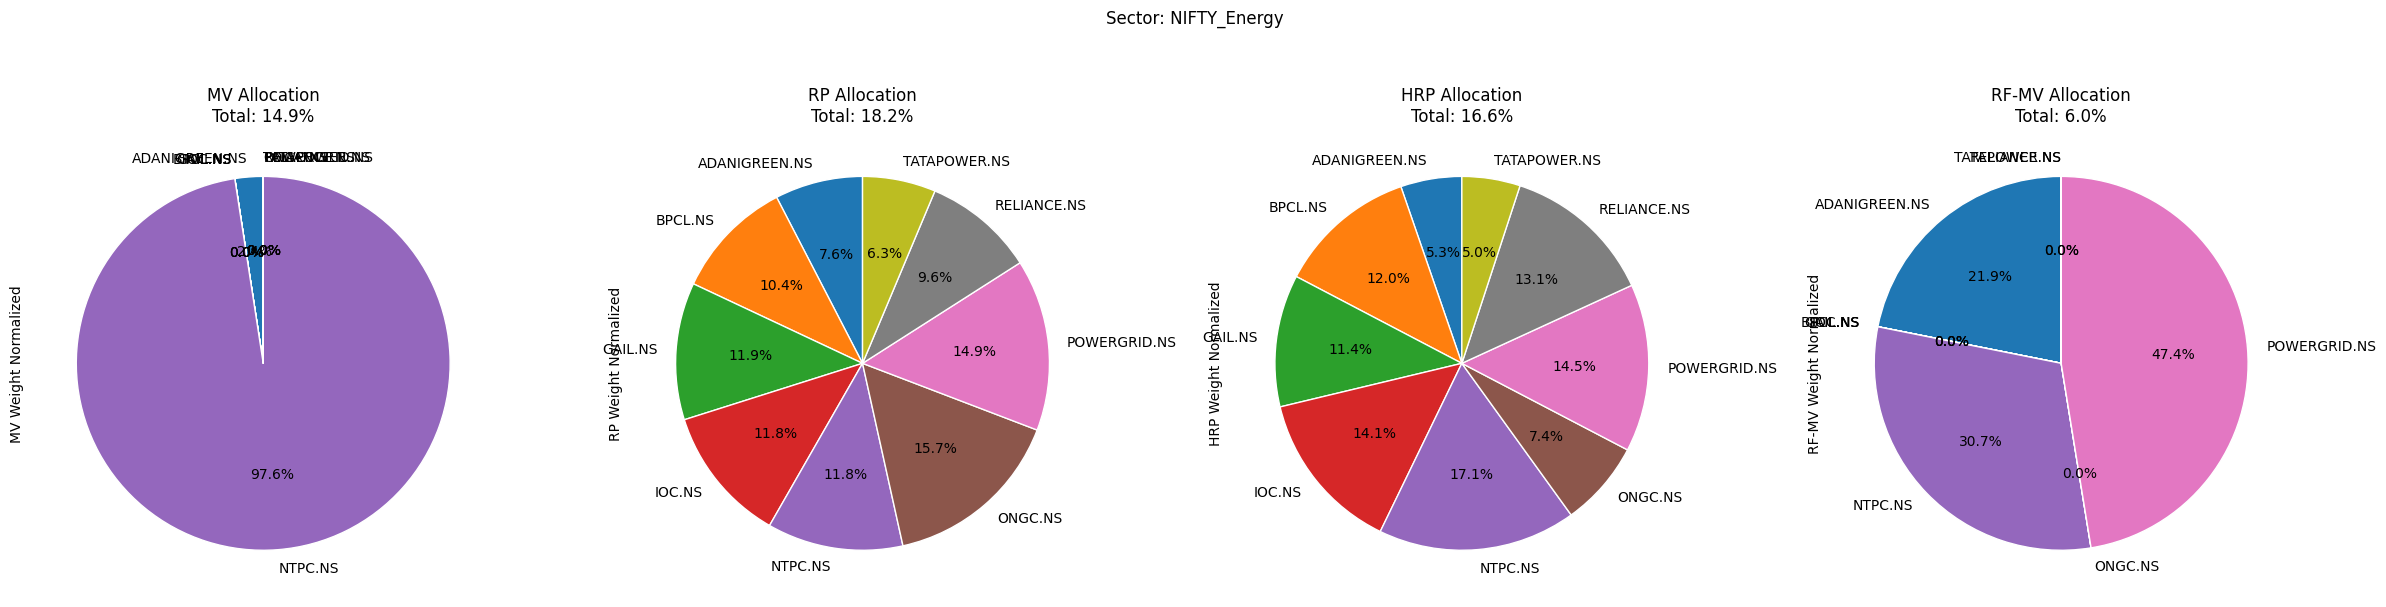

## NIFTY_Transportation

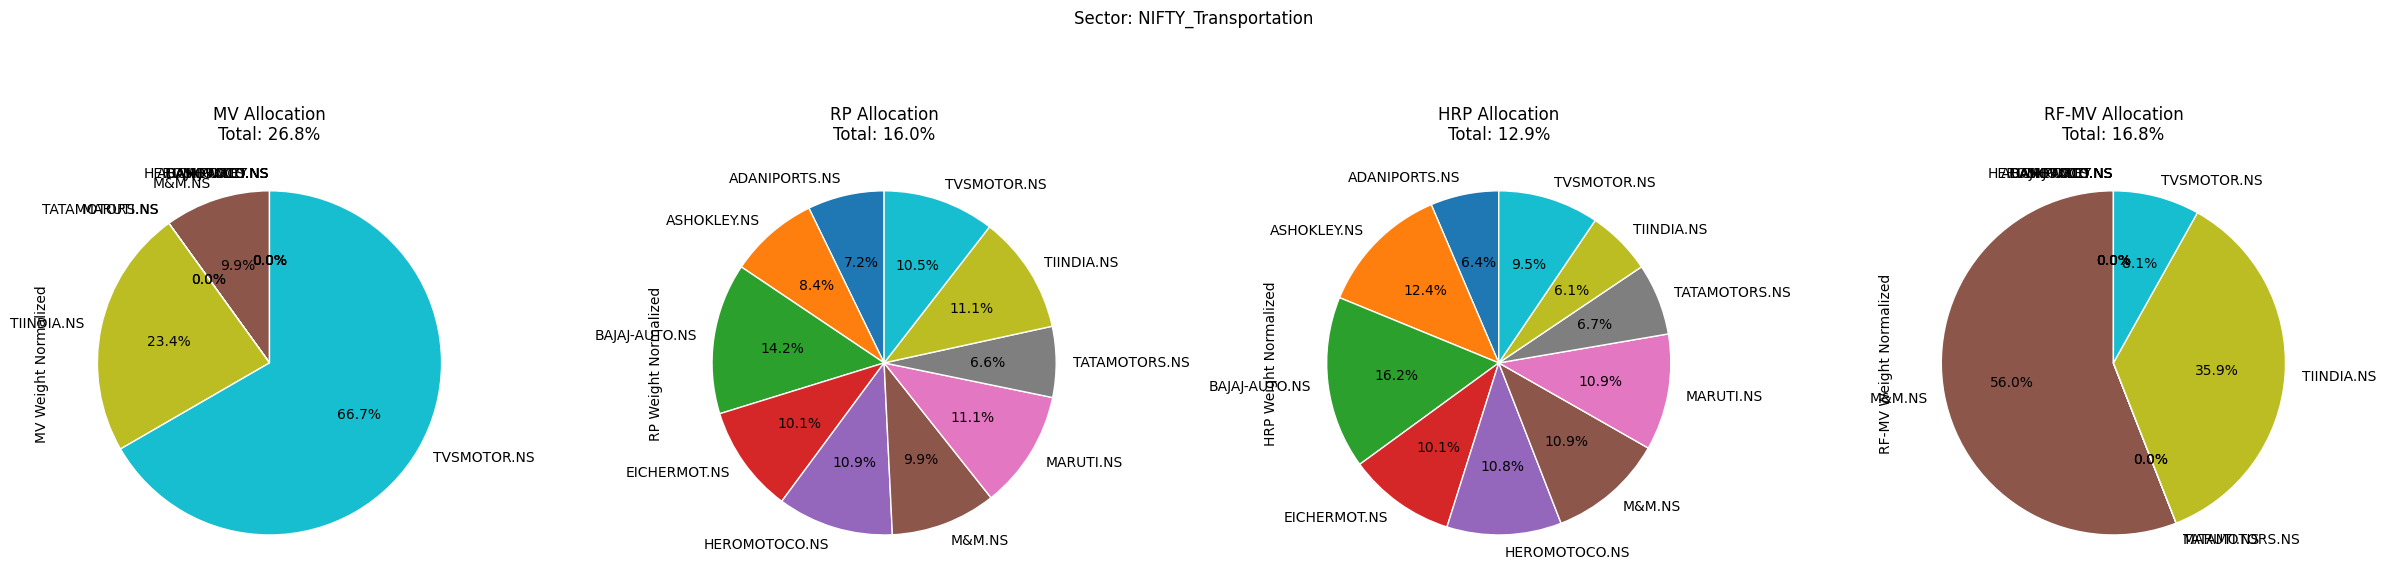

## NIFTY_Infrastructure

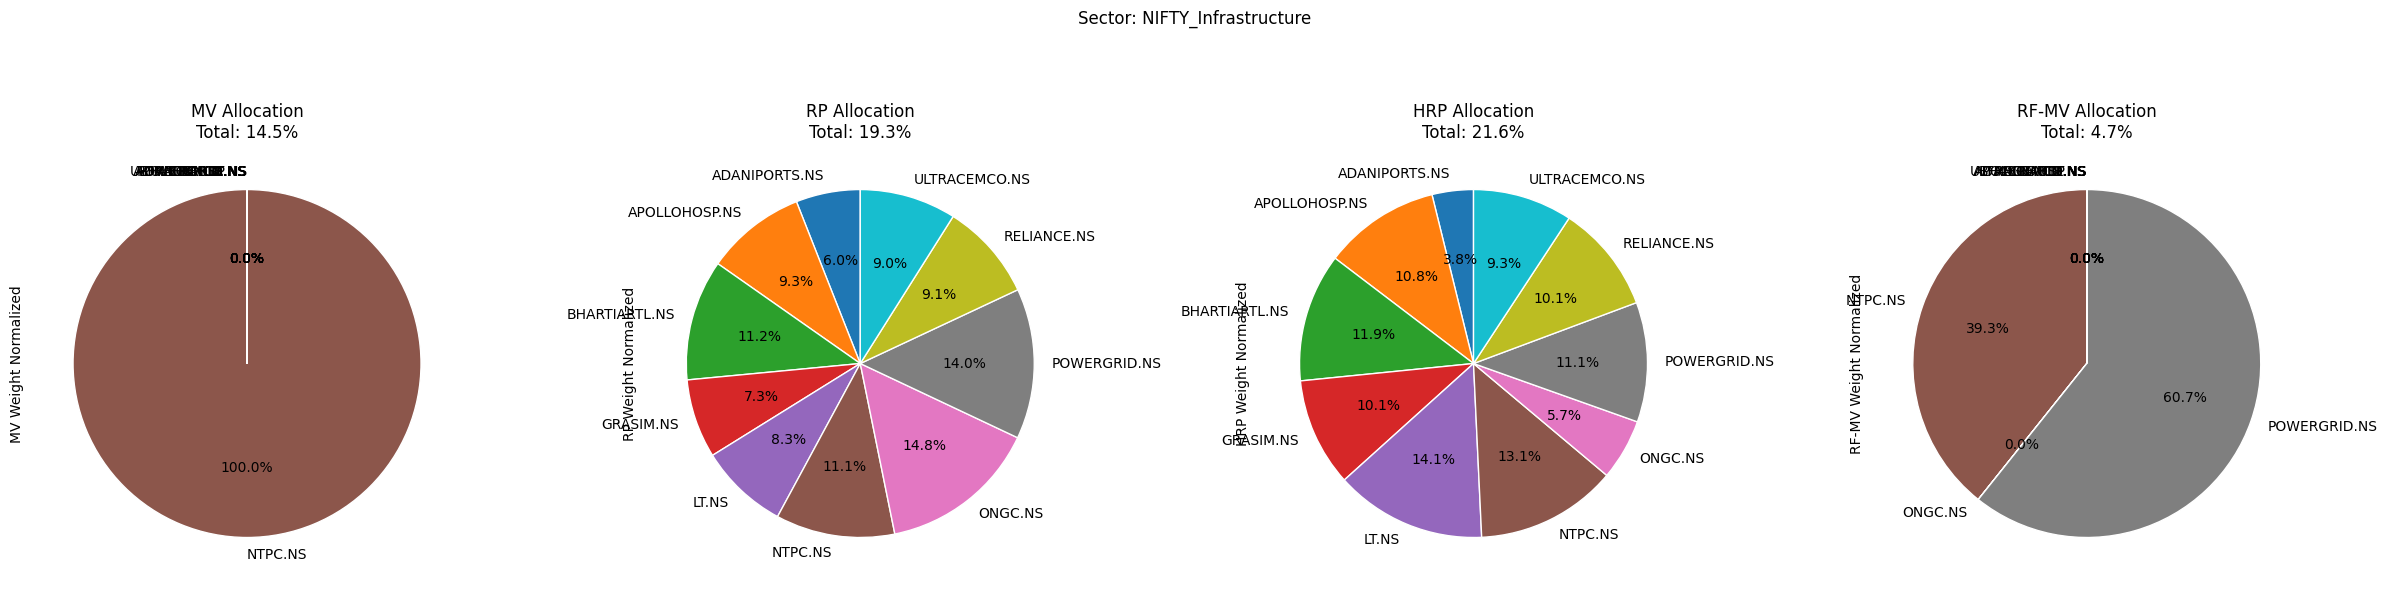

## NIFTY_MNC

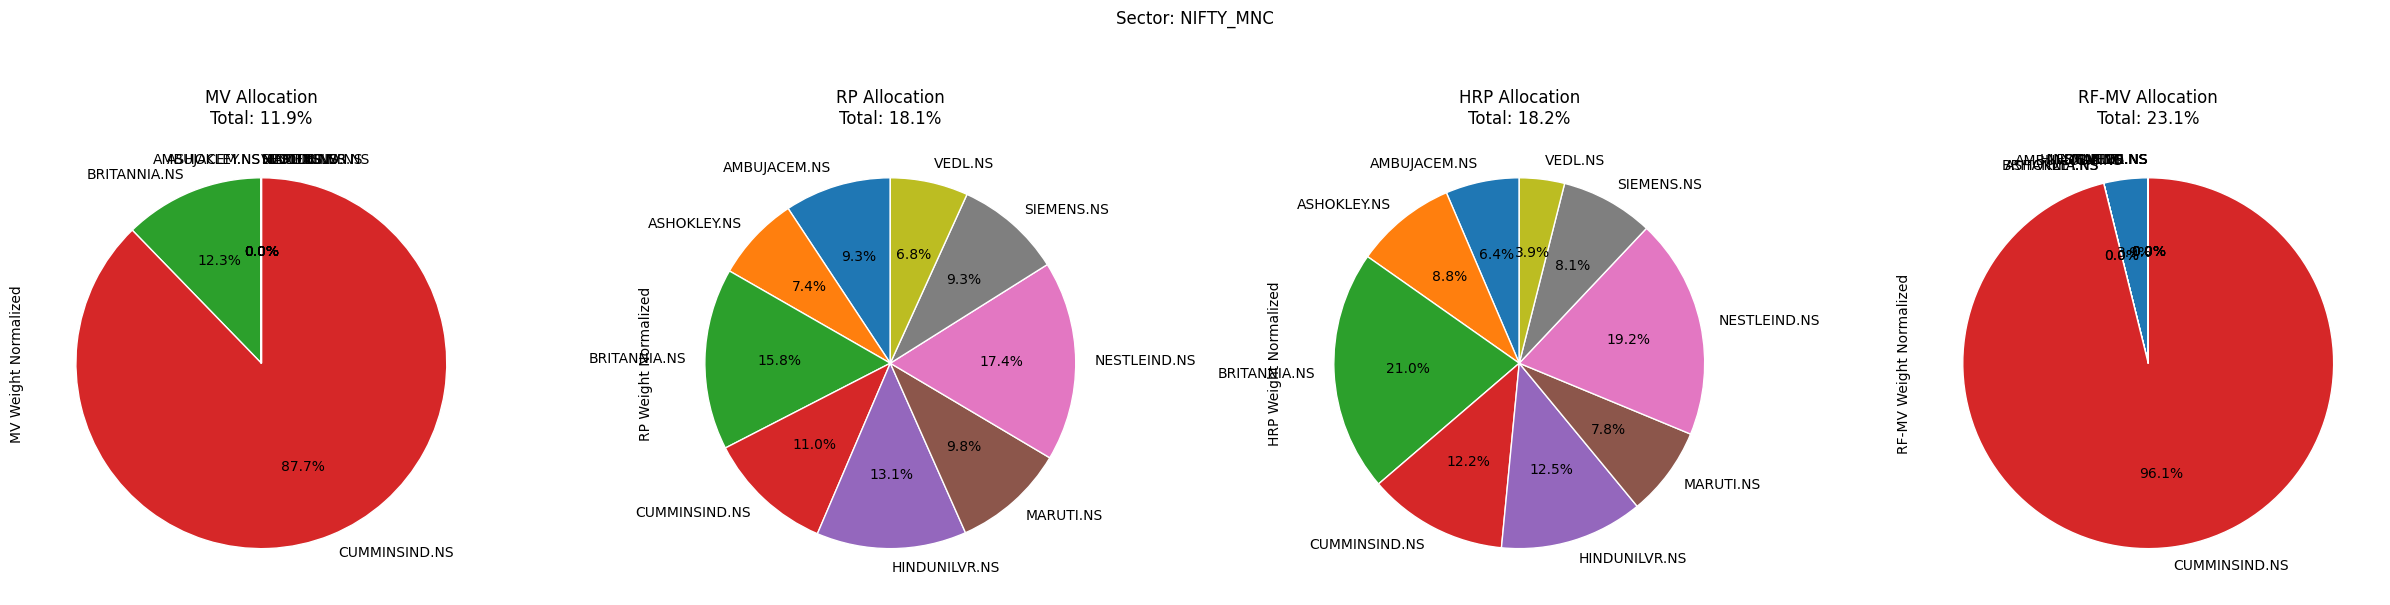

## NIFTY_Consumption

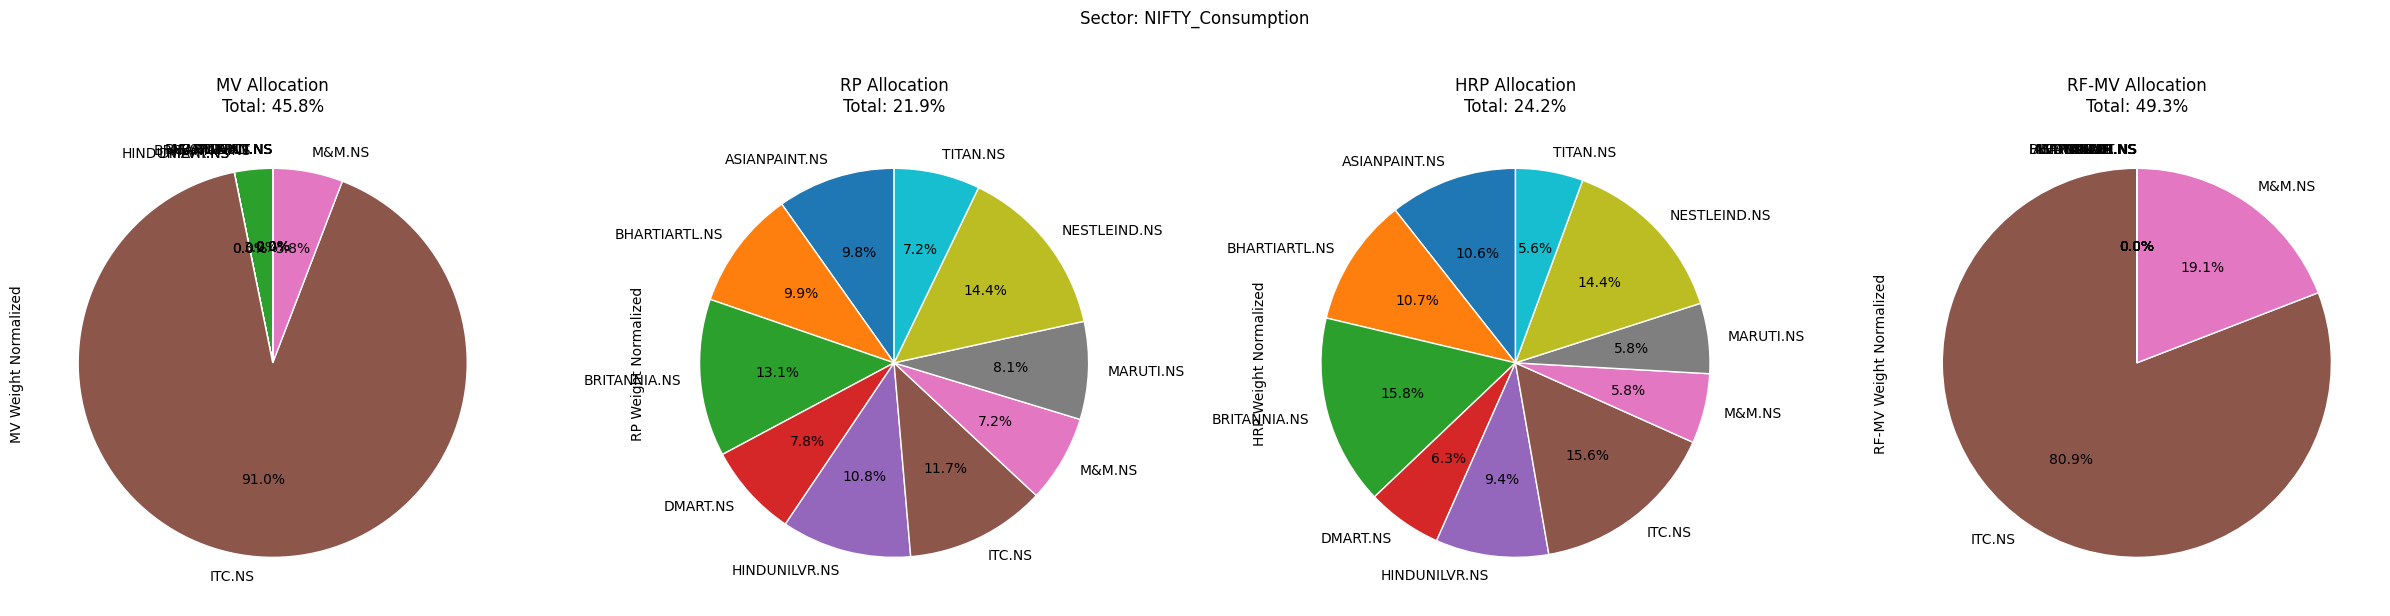

## NIFTY_Services

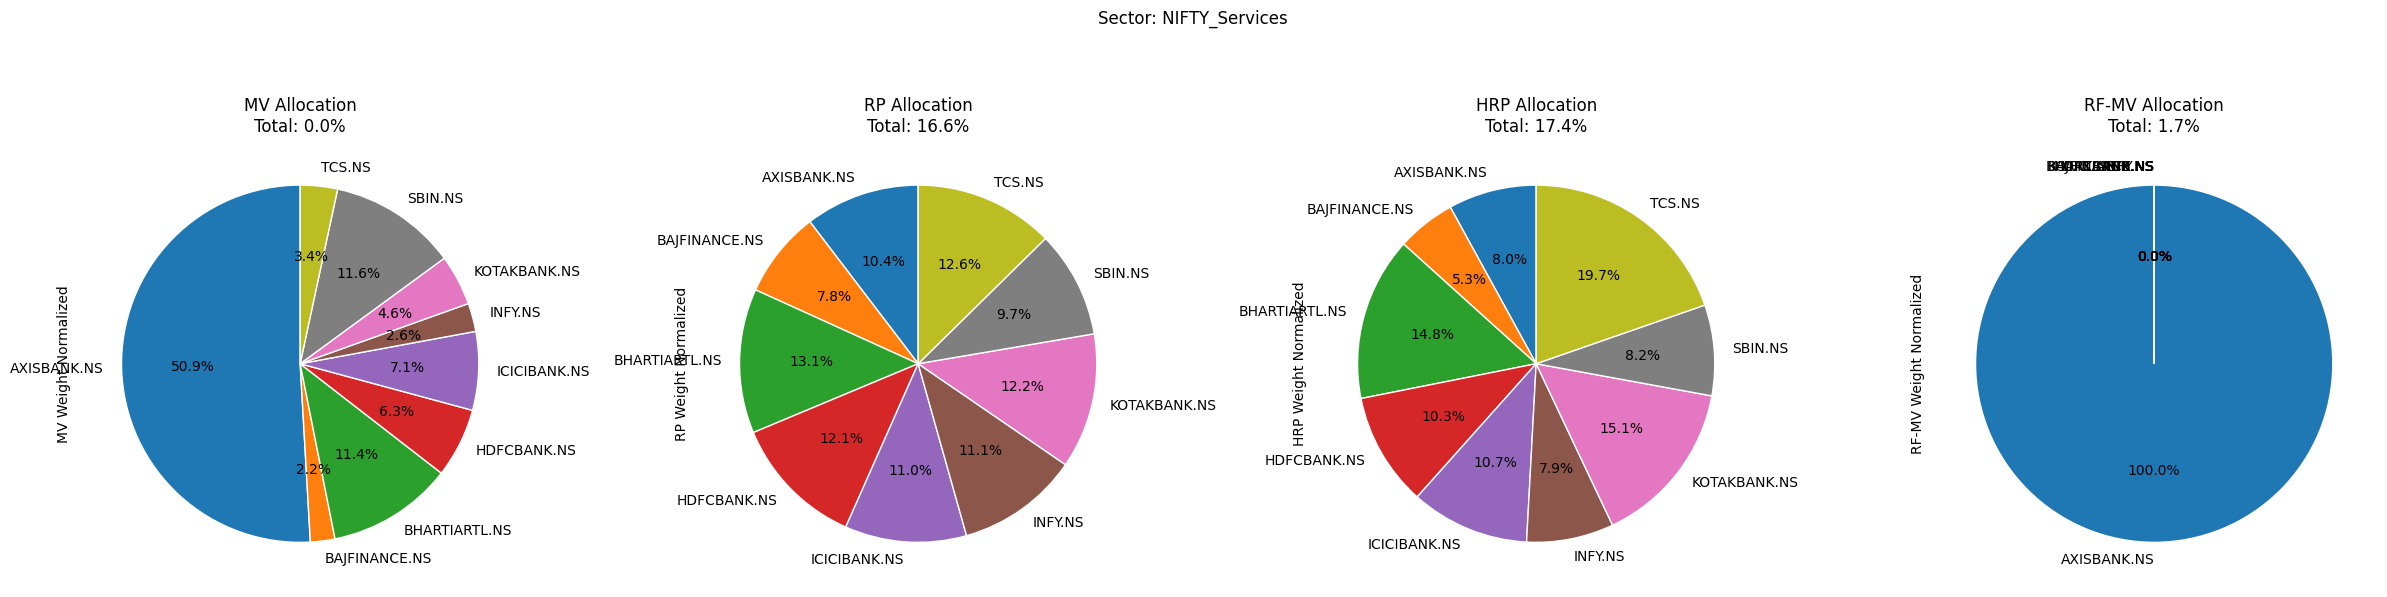

## NIFTY_100_ESG

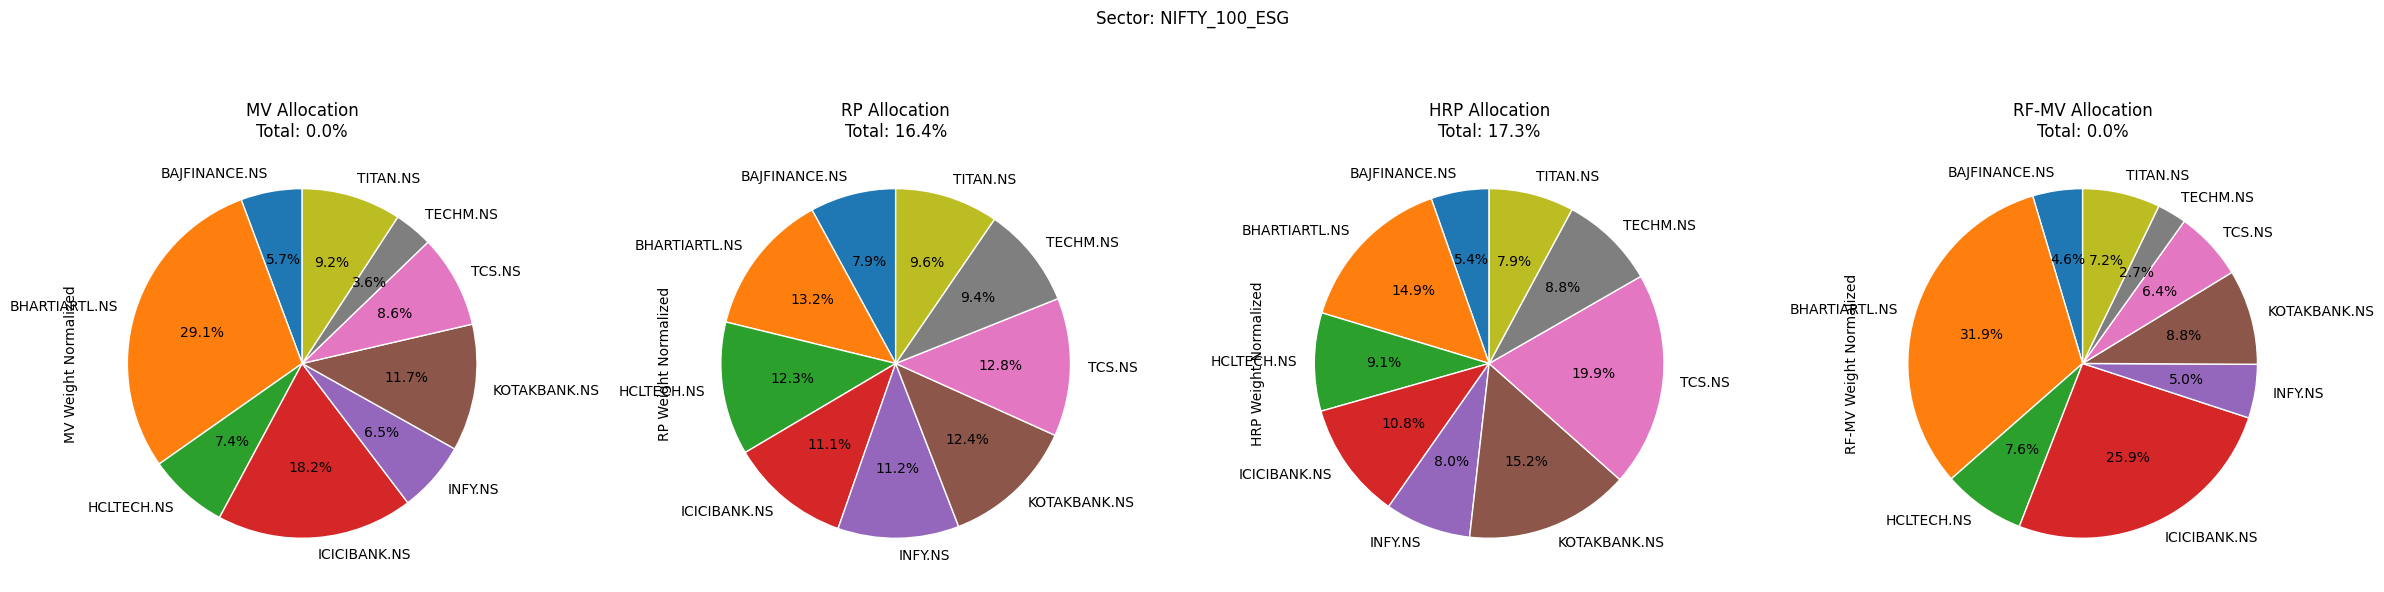

## NIFTY_Housing

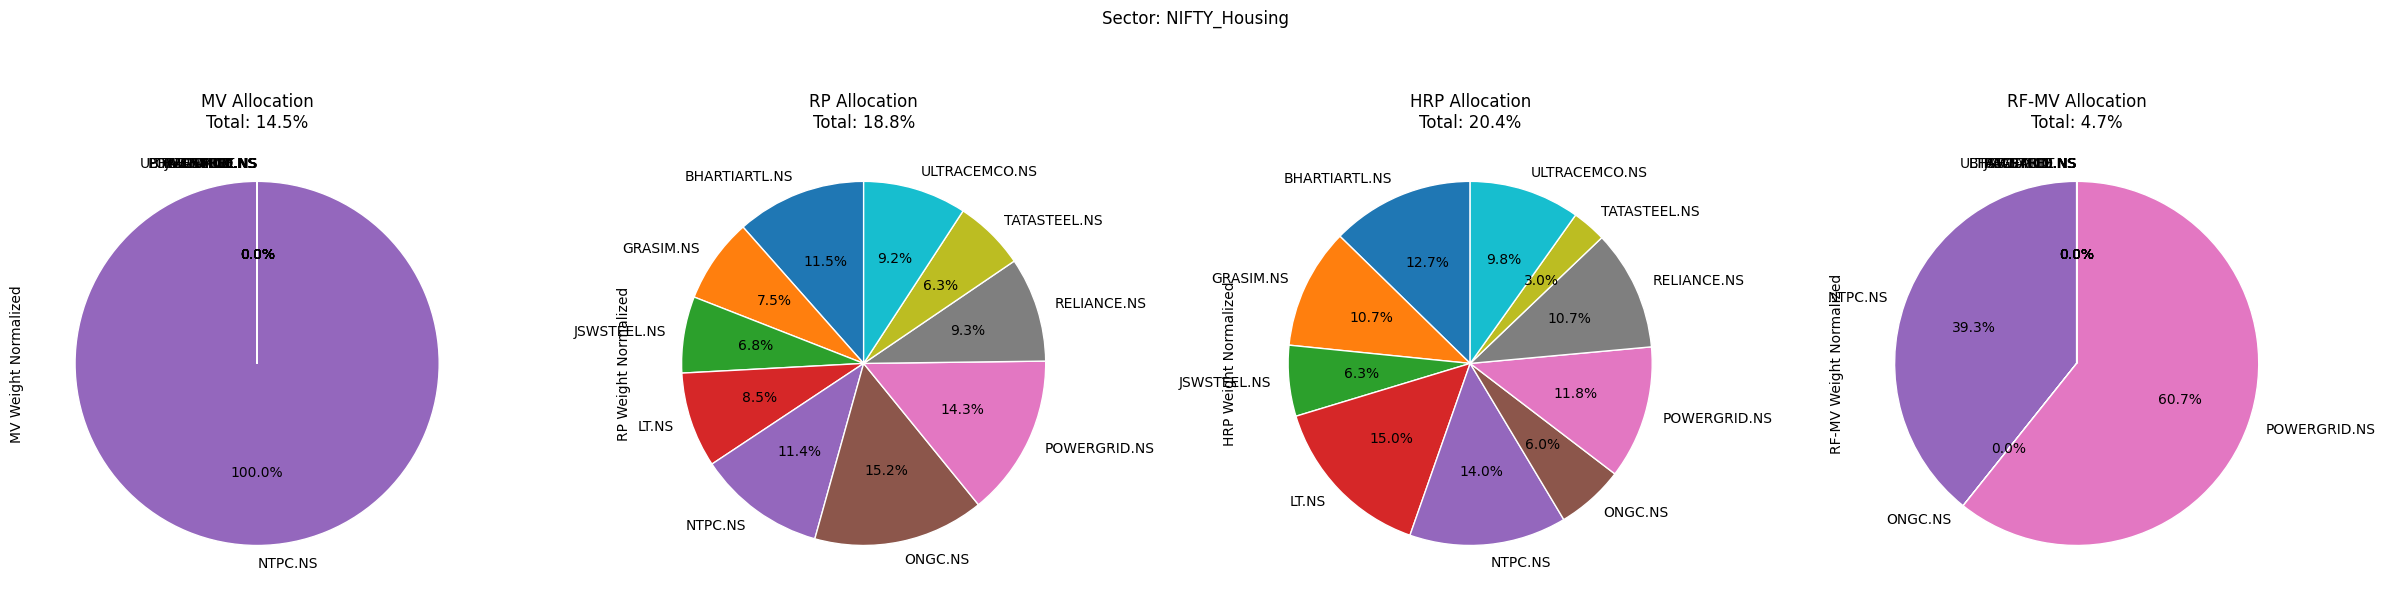

## NIFTY_Manufacturing

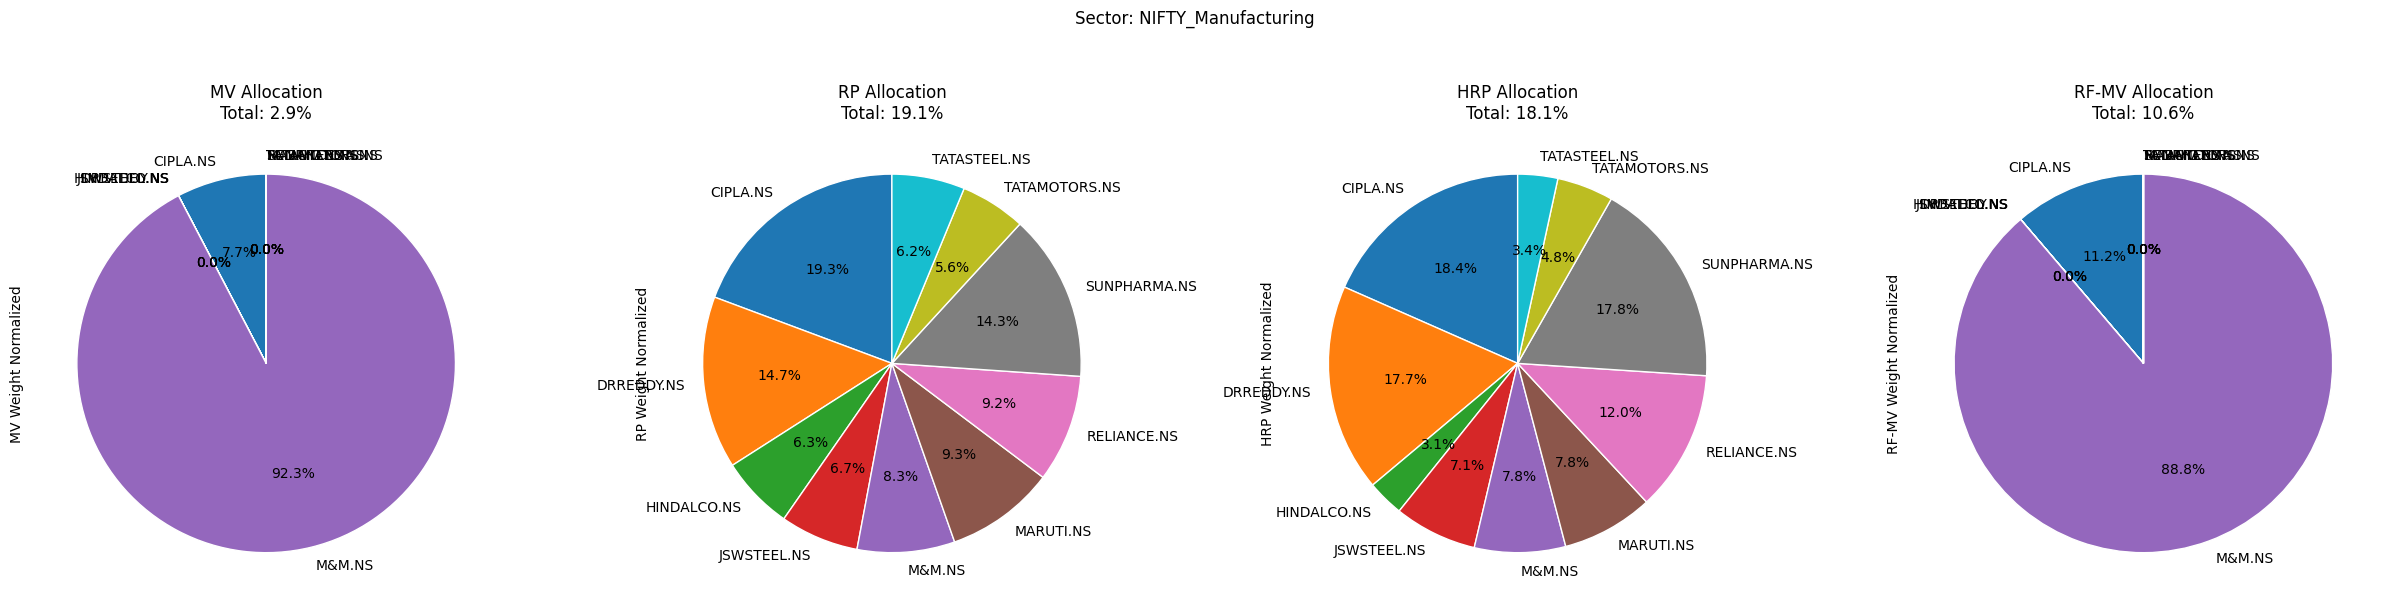

## NIFTY_Commodities

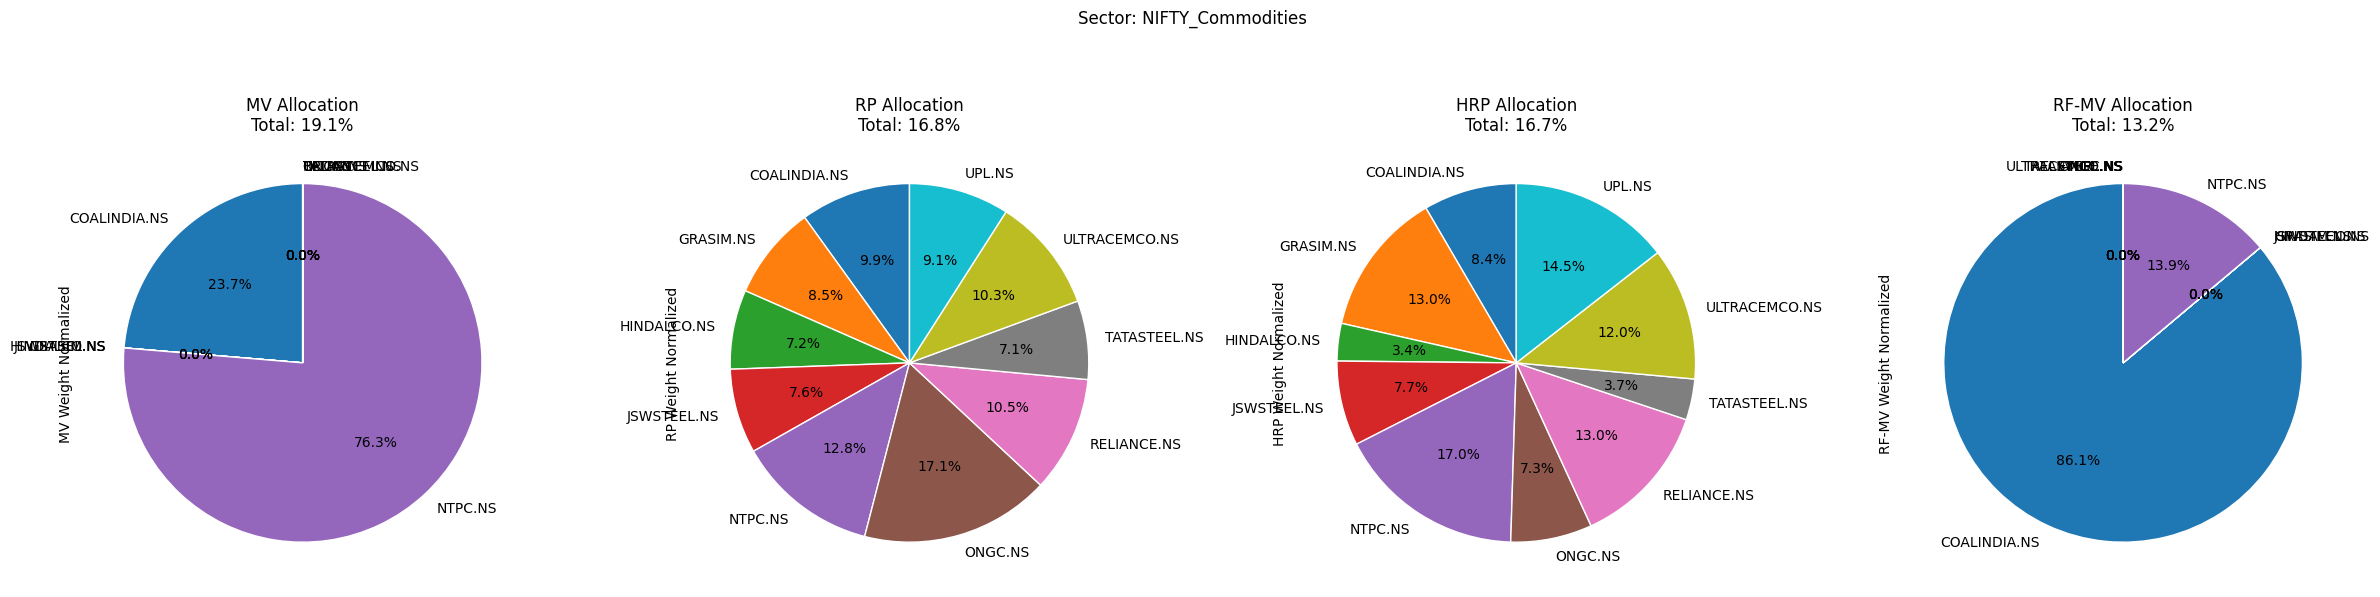

# Sector Cumulative Returns

## NIFTY_Energy

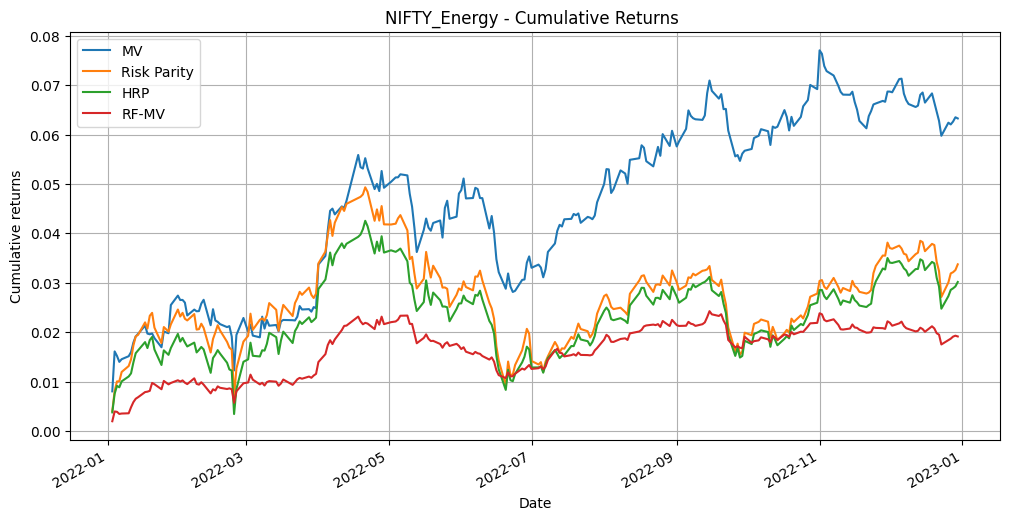

## NIFTY_Transportation

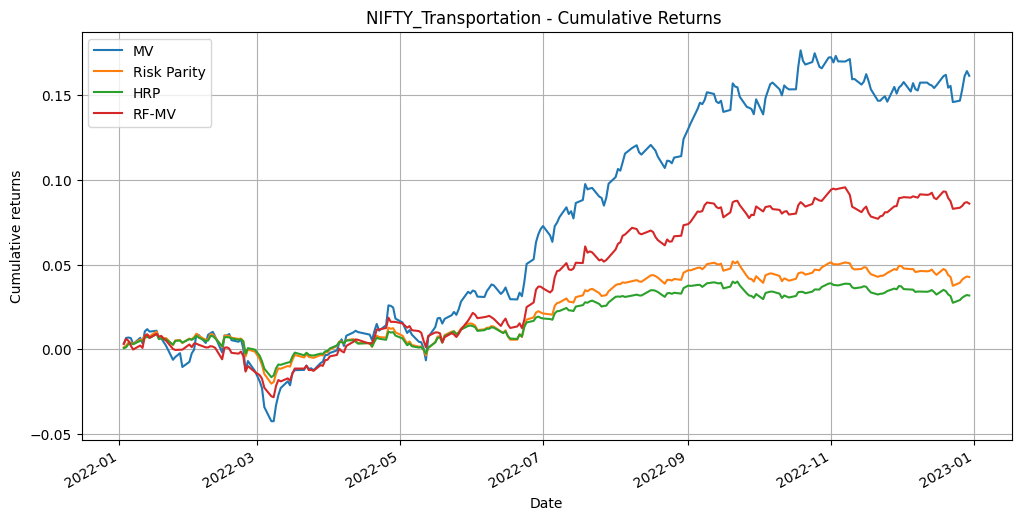

## NIFTY_Infrastructure

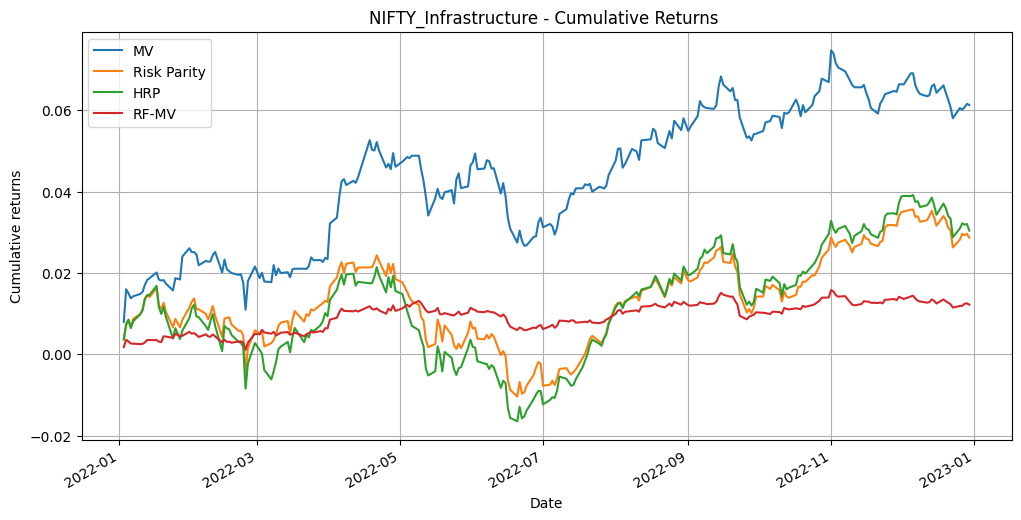

## NIFTY_MNC

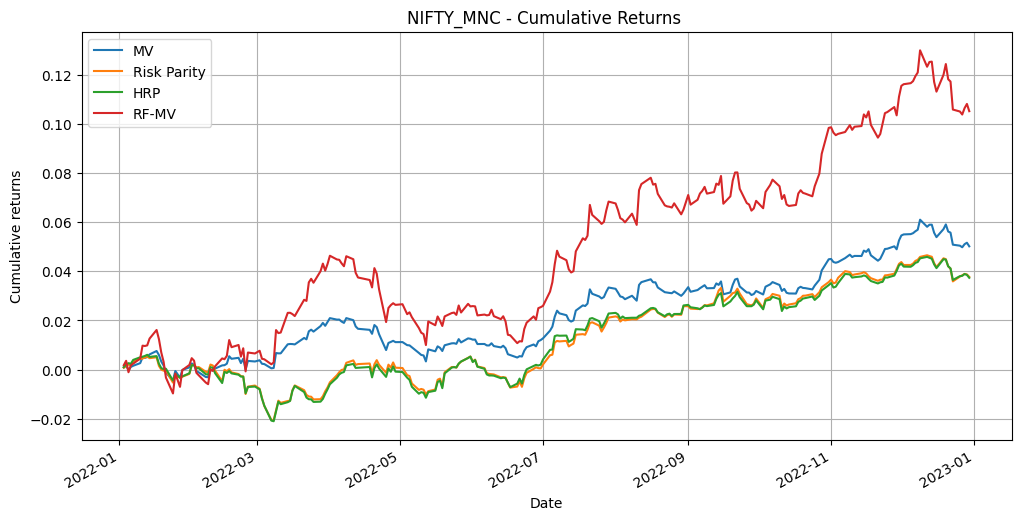

## NIFTY_Consumption

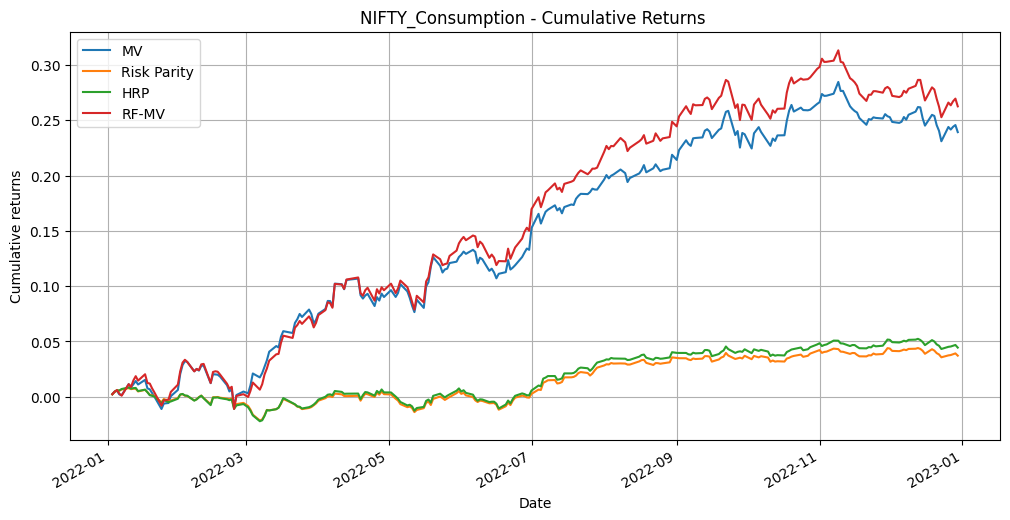

## NIFTY_Services

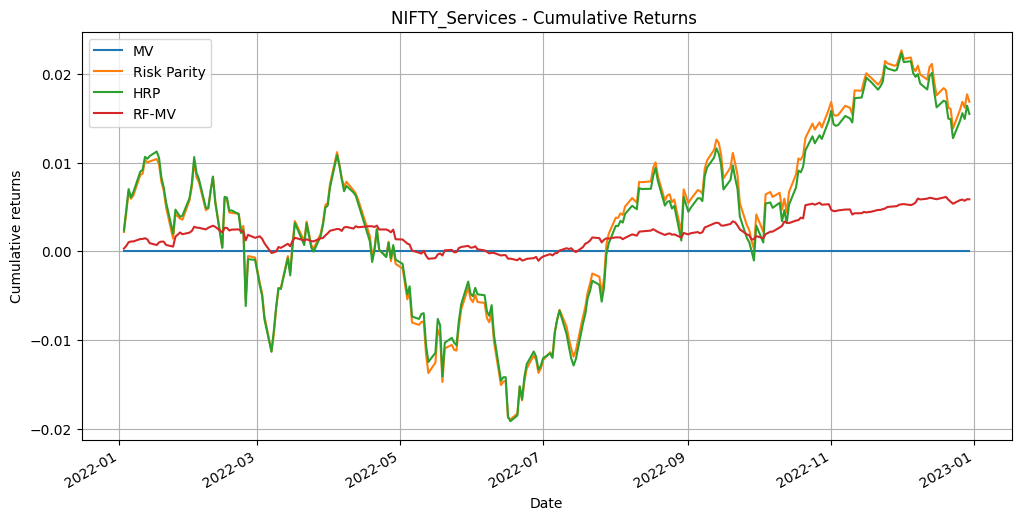

## NIFTY_100_ESG

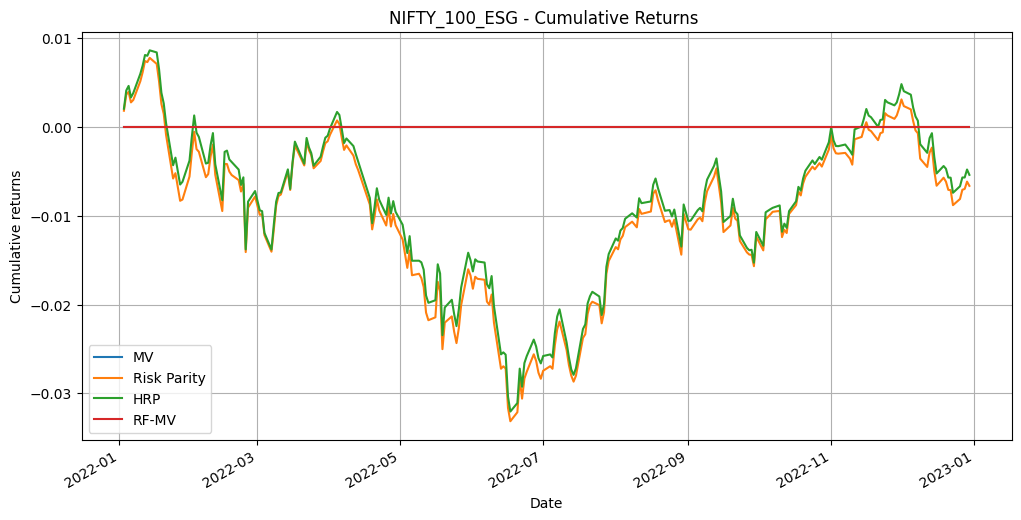

## NIFTY_Housing

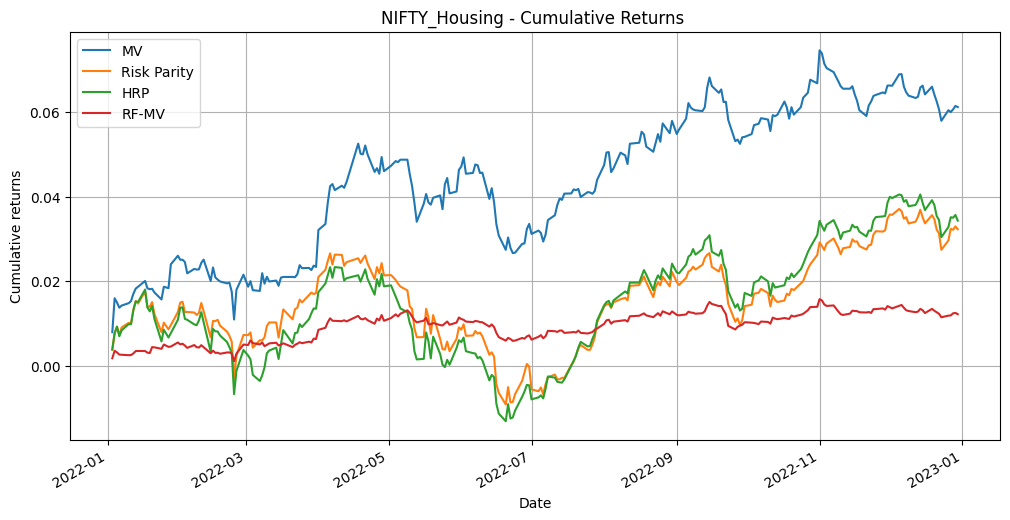

## NIFTY_Manufacturing

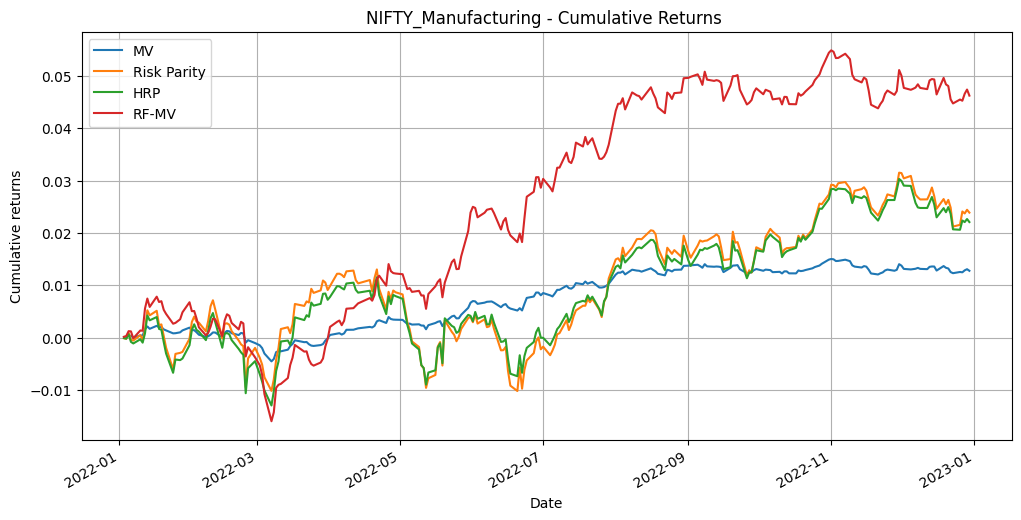

## NIFTY_Commodities

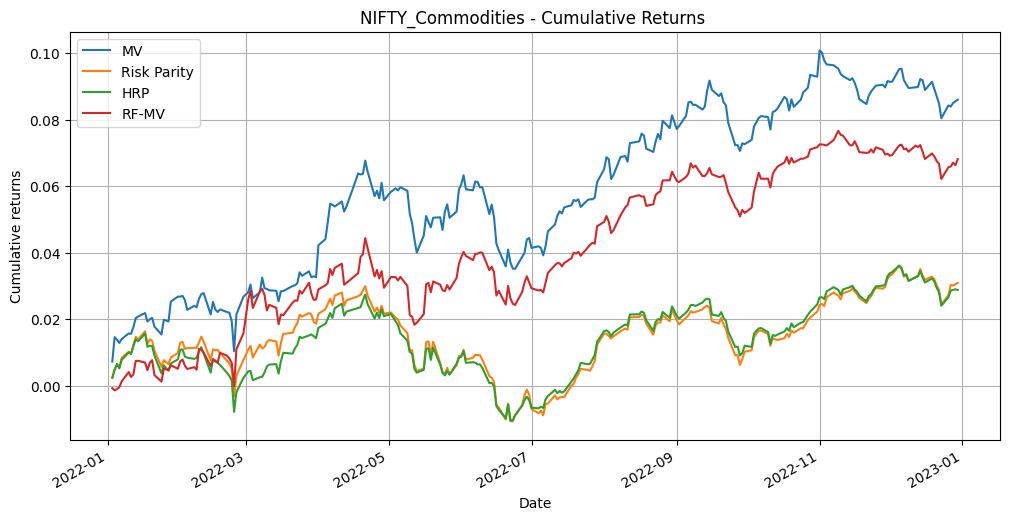

# Sector Cumulative Returns

## NIFTY_Energy

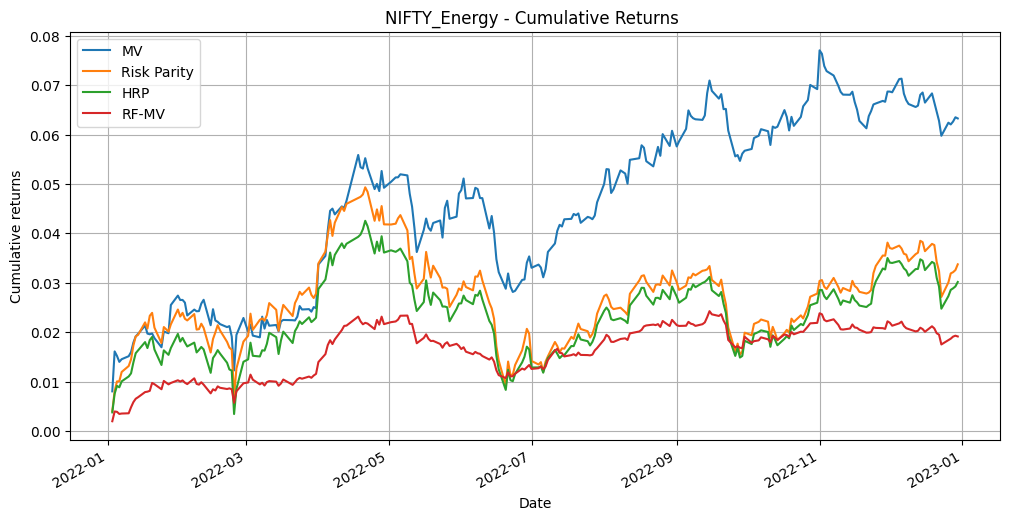

## NIFTY_Transportation

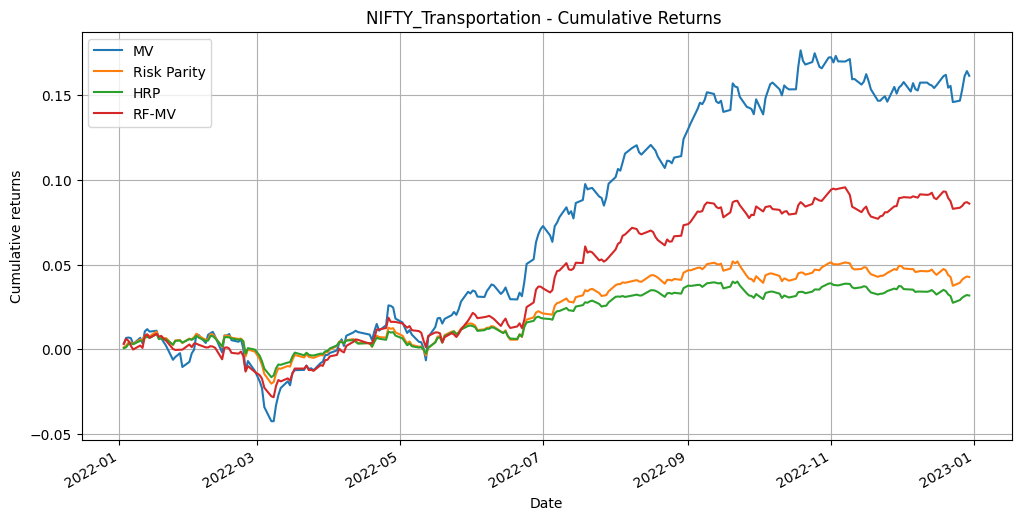

## NIFTY_Infrastructure

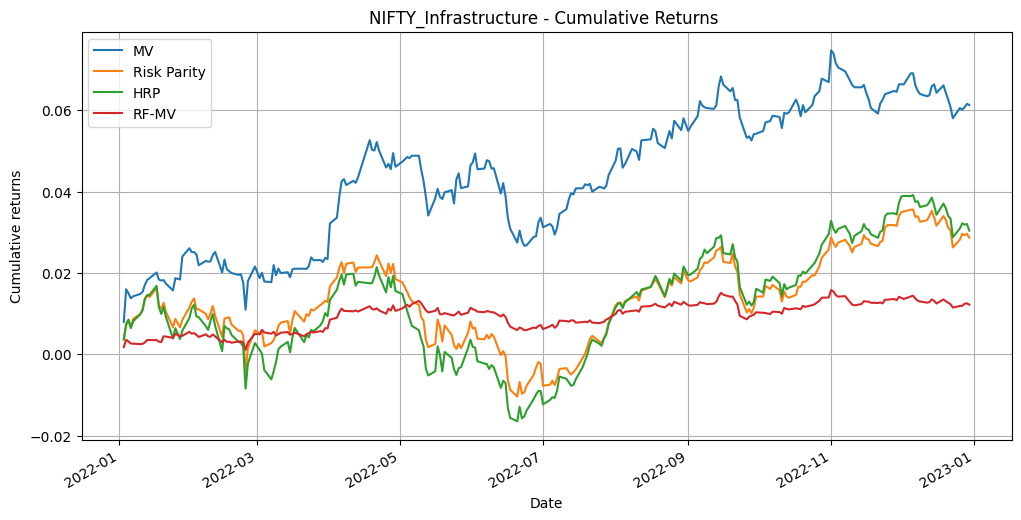

## NIFTY_MNC

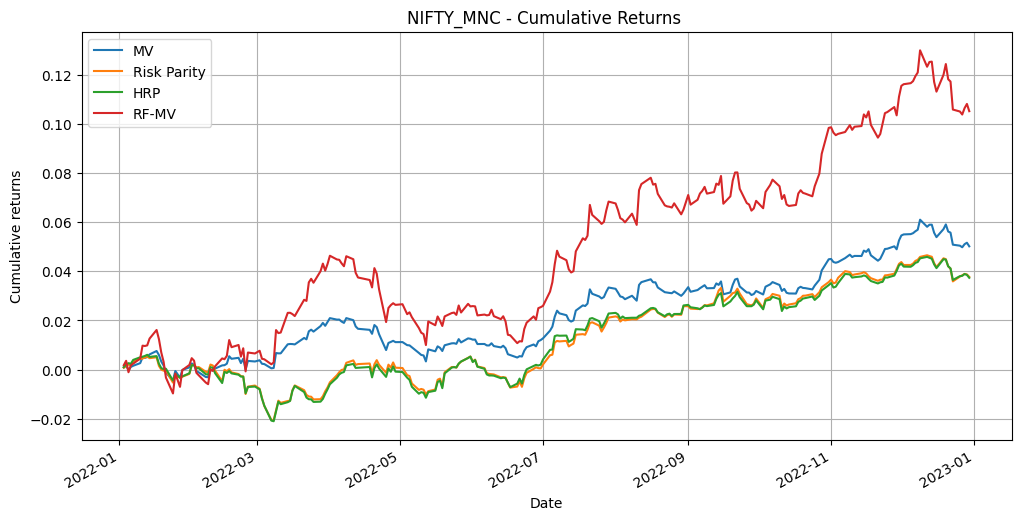

## NIFTY_Consumption

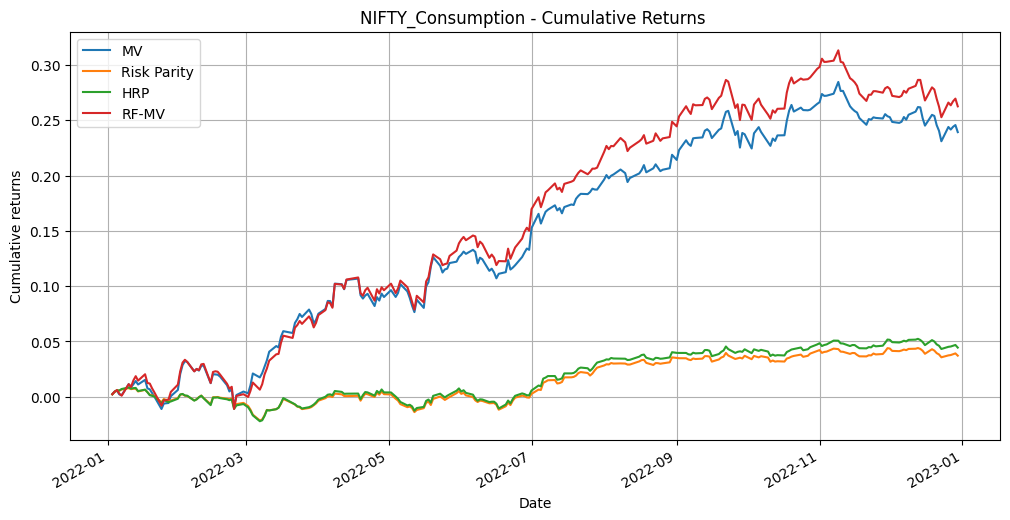

## NIFTY_Services

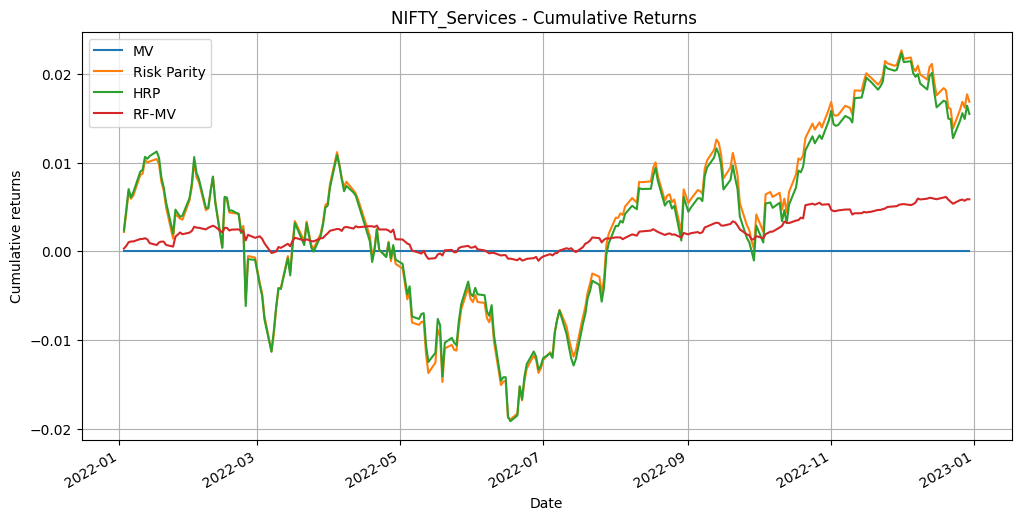

## NIFTY_100_ESG

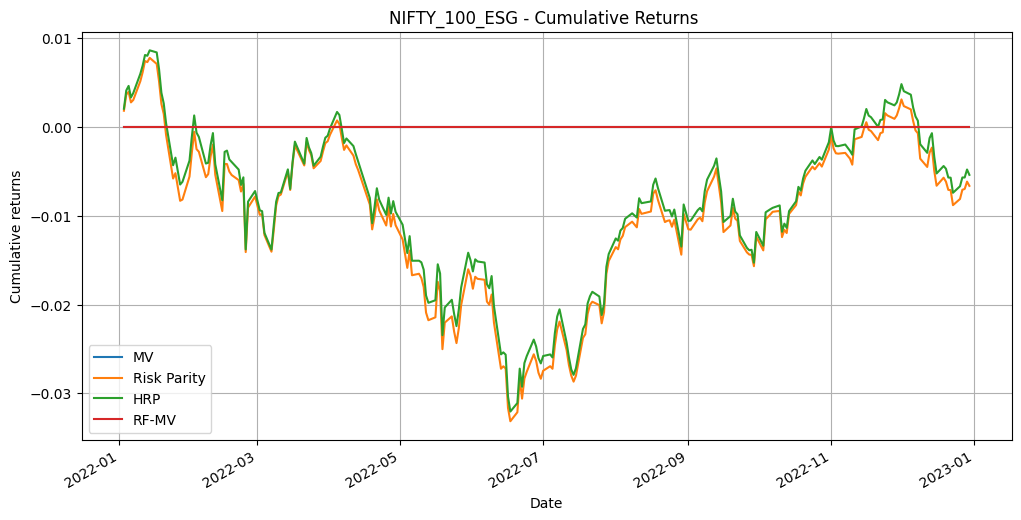

## NIFTY_Housing

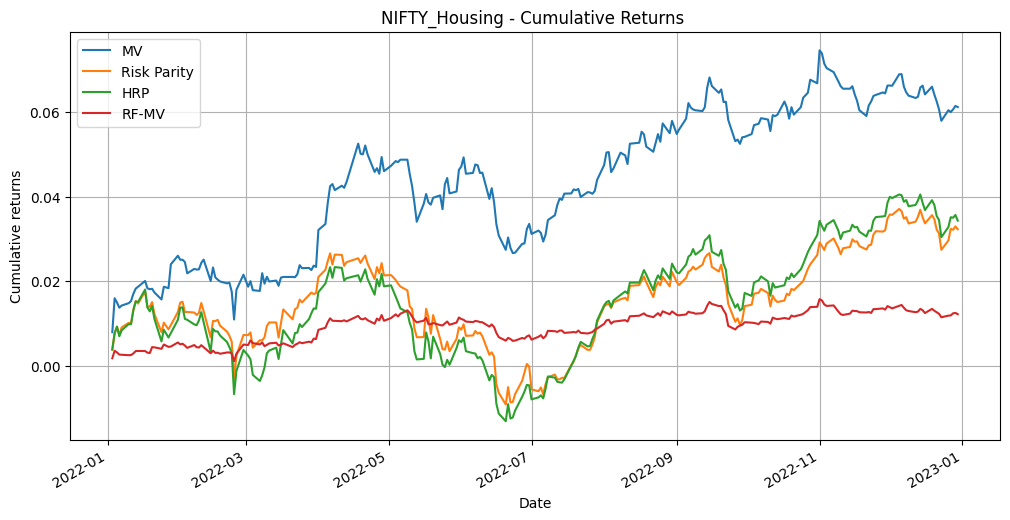

## NIFTY_Manufacturing

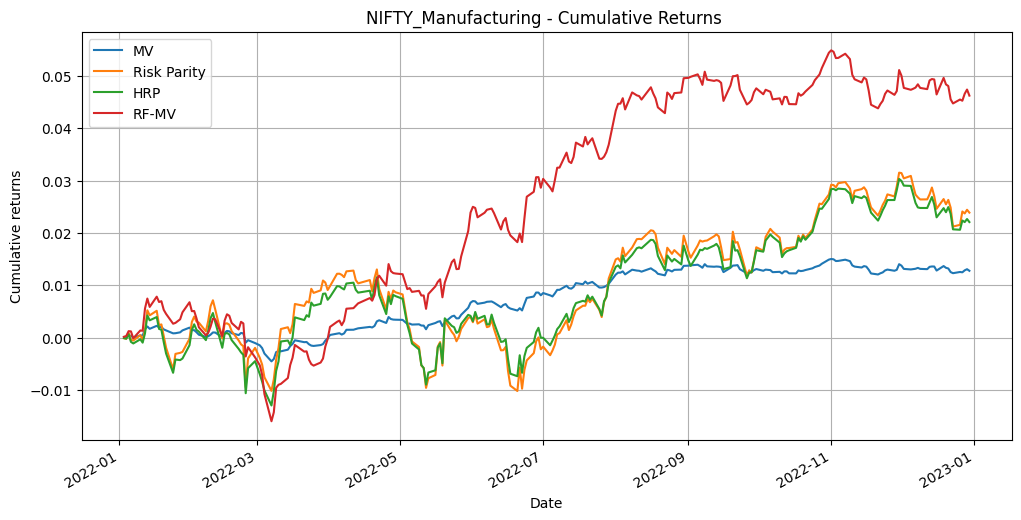

## NIFTY_Commodities

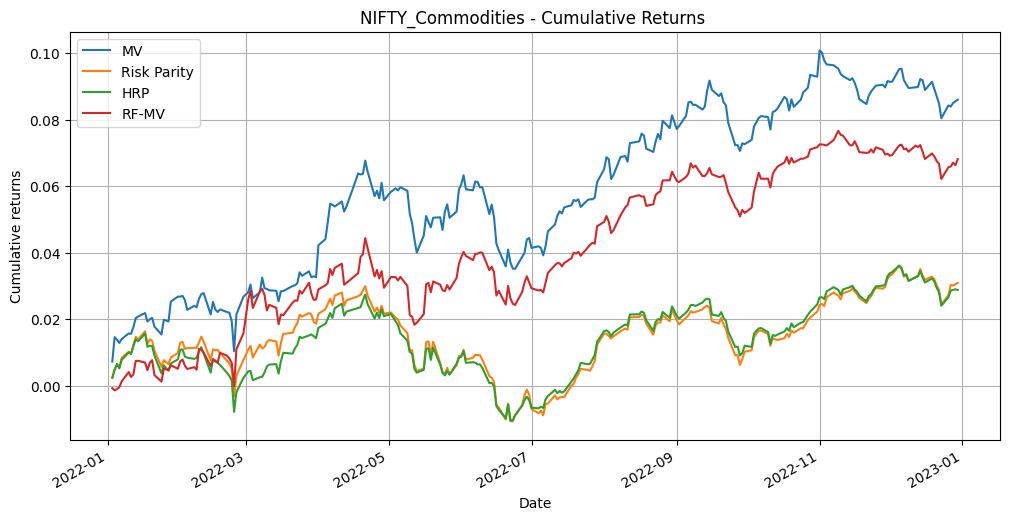

# Overall Portfolio Performance

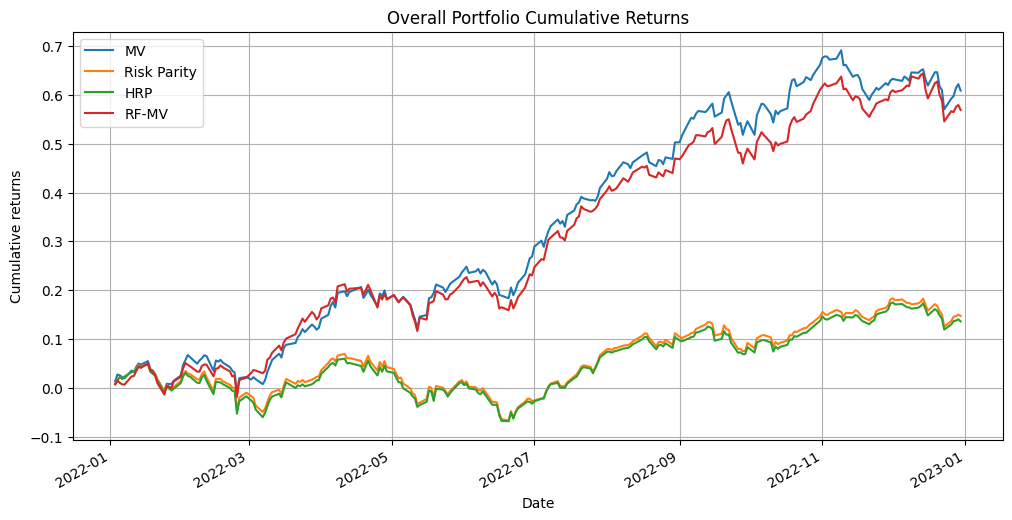

In [104]:
##### --- MAIN EXECUTION ---
display(Markdown("# Sector Weight Tables"))
generate_sector_tables(weights_df)

display(Markdown("# Portfolio Performance Metrics"))
performance_styled = save_table(performance_df, 'Portfolio Performance by Sector', 'sector_performance')
display(performance_styled)
display(FileLink('sector_performance.xlsx', result_html_prefix="Download Excel Table: "))

display(Markdown("# Sector Allocations"))
for sector in weights_df['Sector'].unique():
    display(Markdown(f"## {sector}"))
    plot_sector_visualizations(sector)

display(Markdown("# Sector Cumulative Returns"))
for sector in weights_df['Sector'].unique():
    display(Markdown(f"## {sector}"))
    plot_sector_cumulative_returns(sector)

display(Markdown("# Sector Cumulative Returns"))
for sector in weights_df['Sector'].unique():
    display(Markdown(f"## {sector}"))
    plot_sector_cumulative_returns(sector)


display(Markdown("# Overall Portfolio Performance"))
plt.figure(figsize=(12, 6))
(((1 + (Y_assets @ w_mvo)).cumprod() - 1)).plot(label='MV')
(((1 + (Y_assets @ w_rp)).cumprod() - 1)).plot(label='Risk Parity')
(((1 + (Y_assets @ w_hrp)).cumprod()-1)).plot(label='HRP')
(((1 + (Y_assets @ w_rf_mvo)).cumprod()-1)).plot(label='RF-MV')
plt.title('Overall Portfolio Cumulative Returns')
plt.ylabel('Cumulative returns')
plt.legend()
plt.grid(True)
plt.savefig('overall_cumulative_returns.png', bbox_inches='tight')
plt.show()